# Berlin AirBnB

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re #para la busqueda de palabras en cadena de caracteres
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

## **$1-$ Visualización de los datos**

In [2]:
df_raw = pd.read_csv('listings_summary.csv')

# checking shape
print("The dataset has {} rows and {} columns.".format(*df_raw.shape))

# ... and duplicates
print("It contains {} duplicates.".format(df_raw.duplicated().sum()))

The dataset has 22552 rows and 96 columns.
It contains 0 duplicates.


In [3]:
df_raw.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2015,https://www.airbnb.com/rooms/2015,20181107122246,2018-11-07,Berlin-Mitte Value! Quiet courtyard/very central,Great location! 30 of 75 sq meters. This wood...,A+++ location! This „Einliegerwohnung“ is an e...,Great location! 30 of 75 sq meters. This wood...,none,It is located in the former East Berlin area o...,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,4,3.76
1,2695,https://www.airbnb.com/rooms/2695,20181107122246,2018-11-07,Prenzlauer Berg close to Mauerpark,NaN,In the summertime we are spending most of our ...,In the summertime we are spending most of our ...,none,NaN,...,t,NaN,NaN,f,f,flexible,f,f,1,1.42


In [4]:
df_raw.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

## **$2-$ Procesamiento de datos**

## $2.1-$ Selección de variables para analizar

In [5]:
# define the columns we want to keep
columns_to_keep = ['id', 'space', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'bed_type', 'amenities', 'square_feet', 'price', 'cleaning_fee', 
                   'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',  
                   'instant_bookable', 'is_business_travel_ready', 'cancellation_policy']

df = df_raw[columns_to_keep].set_index('id')
print("The dataset has {} rows and {} columns - after dropping irrelevant columns.".format(*df_raw.shape))

The dataset has 22552 rows and 96 columns - after dropping irrelevant columns.


Tipos diferentes de habitaciones:

In [6]:
df.room_type.value_counts(normalize=True) #normalizados

Private room       0.511440
Entire home/apt    0.475435
Shared room        0.013125
Name: room_type, dtype: float64

Tipos de propiedades:

In [7]:
df.property_type.value_counts(normalize=True) #normalizados

Apartment                 0.896816
Condominium               0.027137
Loft                      0.020397
House                     0.017648
Serviced apartment        0.007760
Hostel                    0.005676
Townhouse                 0.004390
Guest suite               0.003281
Bed and breakfast         0.002838
Guesthouse                0.002527
Hotel                     0.002217
Other                     0.002084
Boutique hotel            0.001907
Bungalow                  0.000887
Boat                      0.000754
Tiny house                0.000532
Camper/RV                 0.000488
Houseboat                 0.000488
Villa                     0.000443
Aparthotel                0.000310
Pension (South Korea)     0.000310
Cabin                     0.000266
Cottage                   0.000177
Resort                    0.000133
Casa particular (Cuba)    0.000089
Train                     0.000089
Castle                    0.000089
Barn                      0.000044
Cave                

## $2.2-$ Columna *Price*

In [8]:
df[['price', 'cleaning_fee', 'extra_people', 'security_deposit']].head(3)

,price,cleaning_fee,extra_people,security_deposit
id,,,,
2015,$60.00,$30.00,$28.00,$200.00
2695,$17.00,$0.00,$0.00,$0.00
3176,$90.00,$50.00,$20.00,$200.00


### Missing Values

In [9]:
# checking Nan's in "price" column
df.price.isna().sum()

0

In [10]:
# Nan's in "cleaning_fee" column
df.cleaning_fee.isna().sum()

7146

In [11]:
#Suponemos que los valores perdidos de la tarifa de limpieza es porque no tiene, ponemos 0$
df.cleaning_fee.fillna('$0.00', inplace=True)
df.cleaning_fee.isna().sum()

0

In [12]:
df.security_deposit.isna().sum()

9361

In [13]:
df.security_deposit.fillna('$0.00', inplace=True)
df.security_deposit.isna().sum()

0

In [14]:
df.extra_people.isna().sum()

0

Eliminamos los signos de dólar en las cuatro columnas y conviertimos los strigs en numéricos:

In [15]:
# clean up the columns (by method chaining)
df.price = df.price.str.replace('$', '').str.replace(',', '').astype(float)
df.cleaning_fee = df.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
df.security_deposit = df.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)
df.extra_people = df.extra_people.str.replace('$', '').str.replace(',', '').astype(float)

In [16]:
df['price'].describe()

count    22552.000000
mean        67.143668
std        220.266210
min          0.000000
25%         30.000000
50%         45.000000
75%         70.000000
max       9000.000000
Name: price, dtype: float64

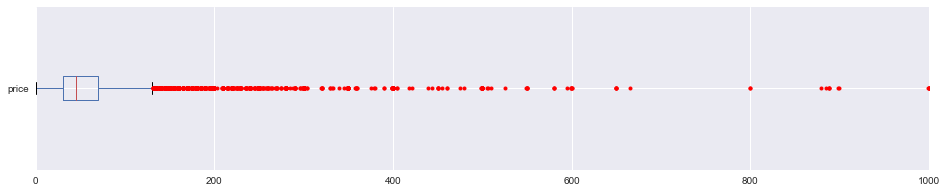

In [17]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['price'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,3))

Vemos que el 75% de los apartamentos cuestan menos de 70$, así que vamos a limitar nuestro dataset a los pisos por debajo de 400$, atambién eliminaremos los pisos que valen 0$:

In [18]:
df.drop(df[ (df.price > 400) | (df.price == 0) ].index, axis=0, inplace=True)

In [19]:
df['price'].describe()

count    22441.000000
mean        57.584377
std         42.162006
min          1.000000
25%         30.000000
50%         45.000000
75%         70.000000
max        400.000000
Name: price, dtype: float64

In [20]:
print("The dataset has {} rows and {} columns - after being price-wise preprocessed.".format(*df.shape))

The dataset has 22441 rows and 23 columns - after being price-wise preprocessed.


## $2.3-$ Estudio de los valores perdidos

In [21]:
#Vemos a ver cuantosdatos tenemos perdidos

total = df.isnull().sum().sort_values(ascending=False) #total de valores perdidos por columna ordenados 
#Porcentaje de valores perdidos respecto al total de cada columna
percent = ((df.isnull().sum())*100)/df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

,Total,Percent
square_feet,21996,98.017022
space,8503,37.890468
description,202,0.900138
bathrooms,32,0.142596
host_has_profile_pic,25,0.111403
bedrooms,18,0.080210
amenities,0,0.000000
instant_bookable,0,0.000000
minimum_nights,0,0.000000
guests_included,0,0.000000


In [22]:
# Borramos directamente las columnas con muchos NaNs
df.drop(columns=['square_feet', 'space'], inplace=True)

In [23]:
# Borramos filas (subset) con NaNs en bathrooms y bedrooms
df.dropna(subset=['bathrooms', 'bedrooms', ], inplace=True)

In [24]:
df.host_has_profile_pic.unique()

array(['t', 'f', nan], dtype=object)

In [25]:
# Reemplazamos los host_has_profile_pic Nan's como si no tuvieran perfil, ponemos false(no)
df.host_has_profile_pic.fillna(value='f', inplace=True)
df.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [26]:
df.isna().sum().sort_values(ascending=False)

description                     202
bedrooms                          0
host_has_profile_pic              0
neighbourhood_group_cleansed      0
latitude                          0
longitude                         0
property_type                     0
room_type                         0
accommodates                      0
bathrooms                         0
cancellation_policy               0
is_business_travel_ready          0
amenities                         0
price                             0
cleaning_fee                      0
security_deposit                  0
extra_people                      0
guests_included                   0
minimum_nights                    0
instant_bookable                  0
bed_type                          0
dtype: int64

In [27]:
print("The dataset has {} rows and {} columns - after having dealt with missing values.".format(*df.shape))

The dataset has 22391 rows and 21 columns - after having dealt with missing values.


## $2.4-$ Distancia al centro de Berlin

In [28]:
from geopy.distance import great_circle

In [29]:
def distance_to_mid(lat, lon):
    berlin_centre = (52.5027778, 13.404166666666667)
    accommodation = (lat, lon)
    return great_circle(berlin_centre, accommodation).km

In [30]:
#creamos una columna con la distancia al centro de Berlin en Km y lo agregamos a nuestro dataset
df['distance'] = df.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [31]:
df.head(1)

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,...,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy,distance
id,,,,,,,,,,,,,,,,,,,,,
2015,Great location! 30 of 75 sq meters. This wood...,t,Mitte,52.534537,13.402557,Guesthouse,Entire home/apt,3,1.0,1.0,...,60.0,30.0,200.0,28.0,1,4,f,f,strict_14_with_grace_period,3.533182


## $2.5-$ Tamaño del alojamiento

In [32]:
df.description.isna().sum()

202

La columna de *description* tiene info que nos interesa. Vamos a extraer:

Todos los números de dos dígitos o tres dígitos que son seguidos por uno de los dos carácteres "s" o "m" (que cubre *sqm*, *square meters*, *m2*, etc.) y puede o no estar conectado por un espacio en blanco. Los números de uno o más de tres dígitos para los tamaños de alojamiento son bastante improbables.

In [33]:
# extract numbers (https://www.programiz.com/python-programming/regex)

#\d{2,3} digitos de 2 o 3
#\s?[smSM] que tengan espacios en blanco delante si empiezan por esas letras
df['size'] = df['description'].str.extract('(\d{2,3}\s?[smSM])', expand=True)

df['size'] = df['size'].str.replace("\D", "") #convertimos cualquier numero no decimal a espacio en blanco

# change datatype of size into float
df['size'] = df['size'].astype(float)

print('NaNs in size_column absolute:     ', df['size'].isna().sum())
print('NaNs in size_column in percentage:', round(df['size'].isna().sum()/len(df),3), '%')

NaNs in size_column absolute:      11721
NaNs in size_column in percentage: 0.523 %


Vemos que aún tenemos unos cuantas propiedades sin saber su tamaño.

In [34]:
df[['description', 'size']].head(10)

,description,size
id,,
2015,Great location! 30 of 75 sq meters. This wood...,75.0
2695,In the summertime we are spending most of our ...,25.0
3176,This beautiful first floor apartment is situa...,68.0
3309,First of all: I prefer short-notice bookings. ...,26.0
7071,Cozy and large room in the beautiful district ...,20.0
9991,4 bedroom with very large windows and outstand...,780.0
14325,The apartment is located on the upper second f...,NaN
16401,Hello future guests! We want to rent our cute ...,55.0
16644,Light and sunny 2-Room-turn of the century-fla...,80.0


In [35]:
df.drop(['description'], axis=1, inplace=True)

### Prediciéndo los missing values perdidos aplicando una regresión usando ML

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22391 entries, 2015 to 29867352
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   host_has_profile_pic          22391 non-null  object 
 1   neighbourhood_group_cleansed  22391 non-null  object 
 2   latitude                      22391 non-null  float64
 3   longitude                     22391 non-null  float64
 4   property_type                 22391 non-null  object 
 5   room_type                     22391 non-null  object 
 6   accommodates                  22391 non-null  int64  
 7   bathrooms                     22391 non-null  float64
 8   bedrooms                      22391 non-null  float64
 9   bed_type                      22391 non-null  object 
 10  amenities                     22391 non-null  object 
 11  price                         22391 non-null  float64
 12  cleaning_fee                  22391 non-null  float64


In [37]:
# Nos quedamos con los float o int (menos lat y long)
sub = df[['accommodates', 'bathrooms', 'bedrooms',  'price', 'cleaning_fee', 
          'security_deposit', 'extra_people', 'guests_included', 'minimum_nights','distance', 'size']]

Entrenamos X_train junto con y_train (ambos con valores conocidos de size), y una vez tengamos entrenado le aplicamos a los datos que tenemos con size desconocido (x_test) que nos sacará los sizes desconocidos.

In [38]:
train_data = sub[sub['size'].notnull()] #nos quedmos para entrenar los que tienen size
test_data  = sub[sub['size'].isnull()] #para testear los que no tienen size

In [39]:
# define X. Eliminamos la columna size que será nuestra variable a predecir
X_train = train_data.drop('size', axis=1)
X_test  = test_data.drop('size', axis=1)

# define y, nuestra varaible predictora
y_train = train_data['size']

In [40]:
print("Shape of Training Data:", train_data.shape)
print("Shape of Test Data:    ",test_data.shape)
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("\nShape of y_train:", y_train.shape)

Shape of Training Data: (10670, 11)
Shape of Test Data:     (11721, 11)

Shape of X_train: (10670, 10)
Shape of X_test: (11721, 10)

Shape of y_train: (10670,)


In [41]:
# import Linear Regression
from sklearn.linear_model import LinearRegression

# instantiate
lg = LinearRegression()

# fit model to training data
lg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
# making predictions
y_test = lg.predict(X_test)

In [43]:
y_test = pd.DataFrame(y_test) #metemos en un dataframe los resultados de la predicción
y_test.columns = ['size']
print(y_test.shape)
y_test.head()

(11721, 1)


,size
0,58.379811
1,97.471386
2,76.857168
3,88.596821
4,61.975387


In [44]:
print(X_test.shape)
X_test.head()

(11721, 10)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance
id,,,,,,,,,,
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,90,5.012297
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3,3.807207
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,60,2.061292
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,3,1.868255
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,90,4.886509


Ahora combinamos *y_test* y *X_test* de nuevo con nuestro dataframe de test. Como podemos ver aquí, el dataframe *X_test* tiene un índice específico que no es compatible con *y_test*, donde los números simplemente comienzan desde 0 en adelante. Por lo tanto, debemos proporcionar a *y_test* el índice *X_test* para asegurarnos de que todo encaja.

In [45]:
# make the index of X_test to an own dataframe
prelim_index = pd.DataFrame(X_test.index) #metemos en un dataframe los indices de X_test
prelim_index.columns = ['prelim'] #le ponemos nombre a esa columna

# ... and concat this dataframe with y_test
y_test = pd.concat([y_test, prelim_index], axis=1)
y_test.set_index(['prelim'], inplace=True) #ponemos como indice la columna prelim
y_test.head()

,size
prelim,
14325,58.379811
20858,97.471386
21869,76.857168
22415,88.596821
28156,61.975387


In [46]:
df2 = pd.concat([X_test, y_test], axis=1)

In [47]:
print(df2.shape)
df2.head()

(11721, 11)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,90,5.012297,58.379811
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3,3.807207,97.471386
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,60,2.061292,76.857168
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,3,1.868255,88.596821
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,90,4.886509,61.975387


In [48]:
df2['size'].isna().sum()

0

In [49]:
# combine train and test data back to a new sub df
sub2 = pd.concat([df2, train_data], axis=0)

print(sub2.shape)
sub2.head()

(22391, 11)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance,size
14325,2,1.0,0.0,70.0,0.0,500.0,0.0,1,90,5.012297,58.379811
20858,4,1.0,2.0,129.0,49.0,500.0,24.0,2,3,3.807207,97.471386
21869,4,1.0,1.0,70.0,40.0,500.0,18.0,2,60,2.061292,76.857168
22415,4,1.0,2.0,98.0,50.0,300.0,25.0,2,3,1.868255,88.596821
28156,2,1.0,0.0,70.0,0.0,1660.0,0.0,1,90,4.886509,61.975387


In [50]:
sub2['size'].isna().sum()

0

Finalmente juntamos todo en el dataframe grande:

In [51]:
# Eliminamos primero las columnas del dataset que acabamos de calcular arriba, para añdir luego estas últimas
df.drop(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee', 
             'security_deposit', 'extra_people', 'guests_included', 'distance', 'size'], 
            axis=1, inplace=True)

In [52]:
# concate back to complete dataframe
df = pd.concat([sub2, df], axis=1)

print(df.shape)
df.head(2)

(22391, 23)


,accommodates,bathrooms,bedrooms,price,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance,...,latitude,longitude,property_type,room_type,bed_type,amenities,minimum_nights,instant_bookable,is_business_travel_ready,cancellation_policy
2015,3,1.0,1.0,60.0,30.0,200.0,28.0,1,4,3.533182,...,52.534537,13.402557,Guesthouse,Entire home/apt,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,Gym,Heating,""Famil...",4,f,f,strict_14_with_grace_period
2695,2,1.0,1.0,17.0,0.0,0.0,0.0,1,2,5.085573,...,52.548513,13.404553,Apartment,Private room,Real Bed,"{Wifi,Kitchen,Elevator,Heating,Washer,Essentia...",2,f,f,flexible


### Investigándo los Sizes

In [53]:
df['size'].isna().sum()

0

In [54]:
df['size'].describe()

count    22391.000000
mean        60.296059
std         80.933328
min          0.000000
25%         25.000000
50%         49.562363
75%         65.038980
max        980.000000
Name: size, dtype: float64

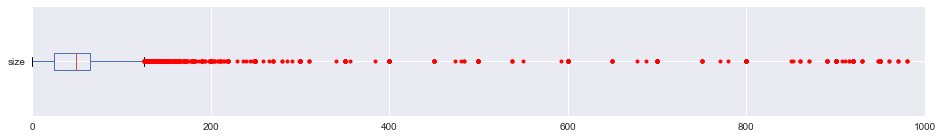

In [55]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df['size'].plot(kind='box', xlim=(0, 1000), vert=False, flierprops=red_square, figsize=(16,2))

Vamos a eliminar los que estén por encima de 300 o valgan 0:

In [56]:
df.drop(df[ (df['size'] == 0.) | (df['size'] > 300.) ].index, axis=0, inplace=True)

print("The dataset has {} rows and {} columns - after being engineered.".format(*df.shape))

The dataset has 21958 rows and 23 columns - after being engineered.


## $2.6-$ Servicios que se dan con el alojamiento *(Amenities)*

In [57]:
df["amenities"].head()

2015    {TV,"Cable TV",Wifi,Kitchen,Gym,Heating,"Famil...
2695    {Wifi,Kitchen,Elevator,Heating,Washer,Essentia...
3176    {Internet,Wifi,Kitchen,"Buzzer/wireless interc...
3309    {Internet,Wifi,"Pets allowed","Pets live on th...
7071    {Wifi,Heating,"Family/kid friendly",Essentials...
Name: amenities, dtype: object

In [58]:
from collections import Counter

results = Counter()
#eliminamos los {}
#reemplazamos los " por espacio
#lstrip('\"') eliminamos los \" por la izquierda (left)
#rstrip('\"') eliminamos los \" por la derecha (right)
#cortamos según encontremos ,

df['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[('Wifi', 20952),
 ('Kitchen', 20809),
 ('Heating', 20657),
 ('Essentials', 19811),
 ('Washer', 18071),
 ('Hair dryer', 14474),
 ('Laptop friendly workspace', 14095),
 ('Hangers', 13514),
 ('Iron', 10876),
 ('Shampoo', 10339),
 ('TV', 9778),
 ('Hot water', 9421),
 ('Family/kid friendly', 7925),
 ('Internet', 7699),
 ('Host greets you', 6469),
 ('Smoke detector', 6245),
 ('Buzzer/wireless intercom', 5963),
 ('Lock on bedroom door', 5138),
 ('Free street parking', 5037),
 ('Refrigerator', 5033),
 ('Dishes and silverware', 4909),
 ('Elevator', 4703),
 ('Cooking basics', 4673),
 ('Bed linens', 4656),
 ('Stove', 4655),
 ('Smoking allowed', 4509),
 ('Oven', 4161),
 ('translation missing: en.hosting_amenity_50', 4095),
 ('First aid kit', 3866),
 ('Cable TV', 3577)]

In [59]:
# create a new dataframe
sub3 = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

Text(0.5, 0, 'Count')

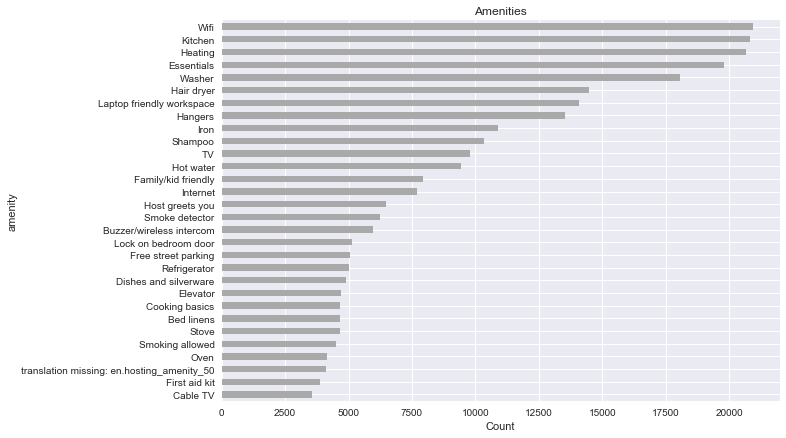

In [60]:
# plot the Top 20
sub3.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count')

Ahora nos quedamos con 5 complementos que son algo únicos y no ofrecen todos los propietarios y creamos columnas en el dataset:

In [61]:
df['Laptop_friendly_workspace'] = df['amenities'].str.contains('Laptop friendly workspace')
df['TV'] = df['amenities'].str.contains('TV')
df['Family_kid_friendly'] = df['amenities'].str.contains('Family/kid friendly')
df['Host_greets_you'] = df['amenities'].str.contains('Host greets you')
df['Smoking_allowed'] = df['amenities'].str.contains('Smoking allowed')

In [62]:
df.drop(['amenities'], axis=1, inplace=True)

## **$3-$ Exploratory Data Analysis *(EDA)***

### Mapa de Precios

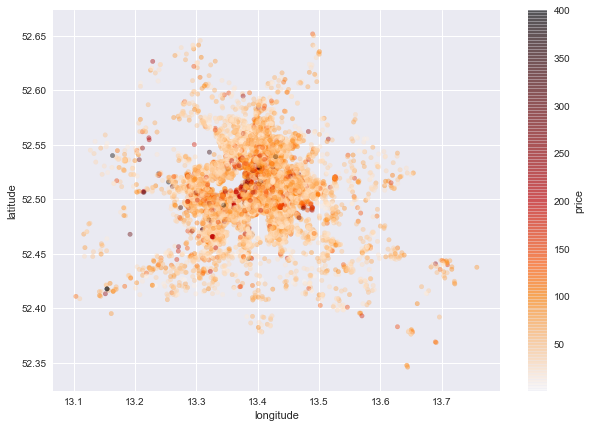

In [63]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False)

### Diferencia ente los barrios y sus precios

Text(0.5, 1.0, 'Number of Accommodations per District')

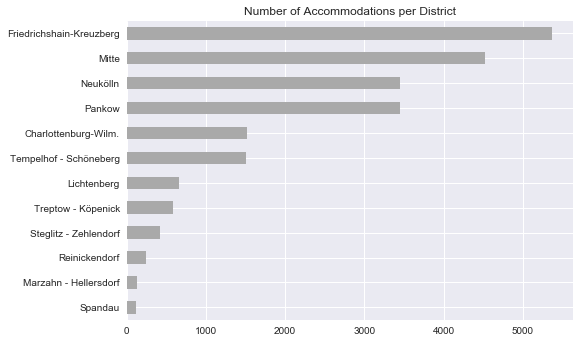

In [64]:
df['neighbourhood_group_cleansed'].value_counts().sort_values().plot(kind='barh', color='darkgrey')
plt.title('Number of Accommodations per District')

Text(0.5, 1.0, '\nMedian Prices by Neighbourhood\n')

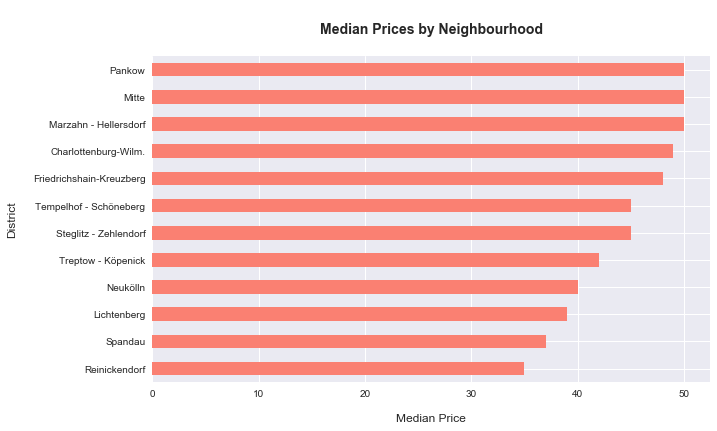

In [65]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_g = pd.DataFrame(df.groupby(['neighbourhood_group_cleansed'])['price'].agg(np.median)) #agrupamos y calculamos la media
df_g.reset_index(inplace=True) #añadimos indice

# plot this 
df_g.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='neighbourhood_group_cleansed', y='price', 
                figsize=(10,6), legend=False, color='salmon')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nMedian Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

Text(0.5, 0.98, '')

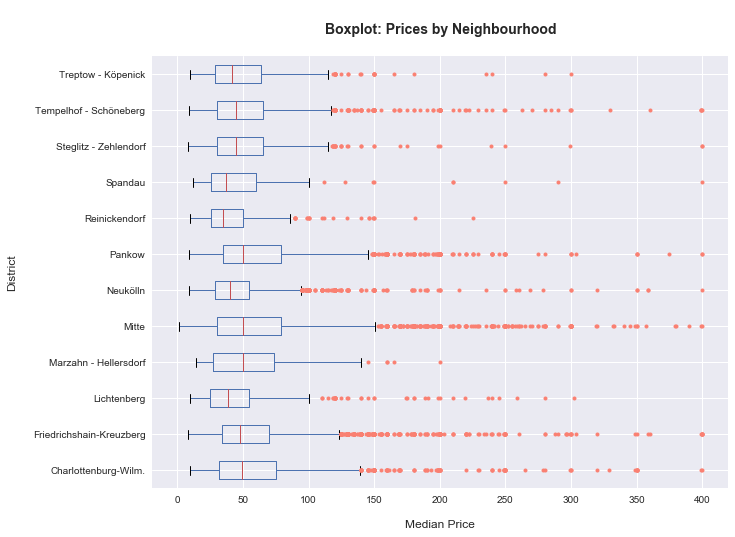

In [66]:
red_square = dict(markerfacecolor='salmon', markeredgecolor='salmon', marker='.')

df.boxplot(column='price', by='neighbourhood_group_cleansed', 
           flierprops=red_square, vert=False, figsize=(10,8))

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nBoxplot: Prices by Neighbourhood\n', fontsize=14, fontweight='bold')

plt.suptitle('')

### Diferencias de precios según distancia al centro de Berlín

Text(0.5, 1.0, '\nRelation between Distance & Median Price\n')

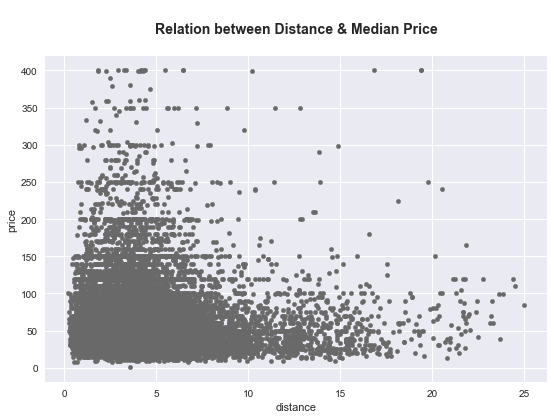

In [67]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')

plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold')

Text(0.5, 1, '\nRelation between Distance & Median Price\n')

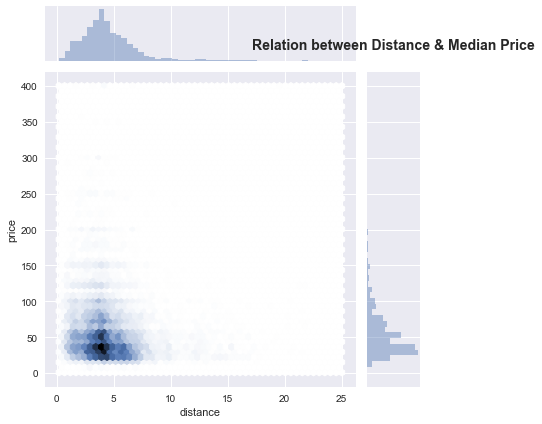

In [68]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelation between Distance & Median Price\n', fontsize=14, fontweight='bold')

### Diferencias de precio por tamaño de alojamiento

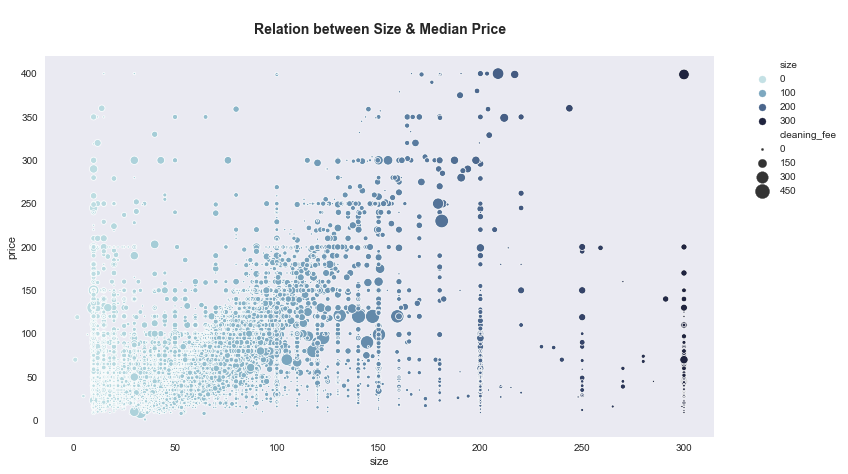

In [69]:
sns.set_style("dark")
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

fig, ax = plt.subplots(figsize=(12,7))
ax = sns.scatterplot(x="size", y="price", size='cleaning_fee', sizes=(5, 200),
                      hue='size', palette=cmap,  data=df)

plt.title('\nRelation between Size & Median Price\n', fontsize=14, fontweight='bold')

# putting legend out of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Diferencias de precio por número de habitaciones

Text(0.5, 1, '\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n')

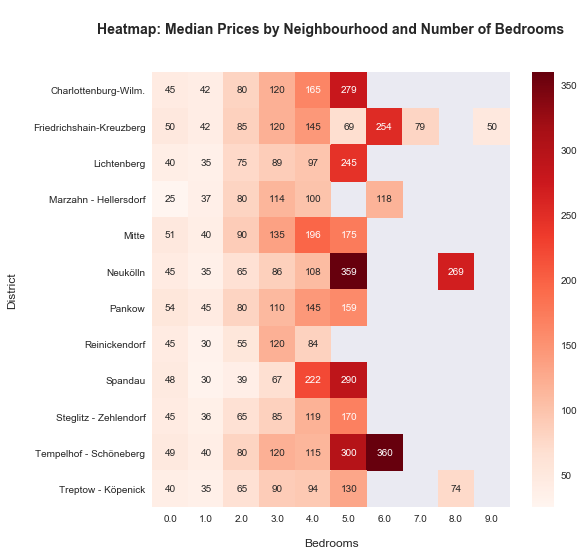

In [70]:
plt.figure(figsize=(8,8))
sns.heatmap(df.groupby(['neighbourhood_group_cleansed', 'bedrooms']).price.median().unstack(), 
            cmap='Reds', annot=True, fmt=".0f")

plt.xlabel('\nBedrooms', fontsize=12)
plt.ylabel('District\n', fontsize=12)
plt.title('\nHeatmap: Median Prices by Neighbourhood and Number of Bedrooms\n\n', fontsize=14, fontweight='bold')

### Diferencias de precio por política de cancelación

Text(0.5, 1.0, '\nMedian Prices by Cancellation Policy\n')

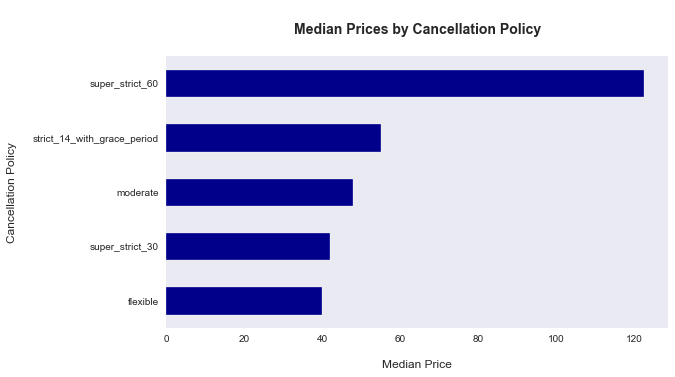

In [71]:
# group_by neighbourhood groups, take the median price and store new values in sub_df 
df_g = pd.DataFrame(df.groupby(['cancellation_policy'])['price'].agg(np.median))
df_g.reset_index(inplace=True)

# plot this 
df_g.sort_values(by=['price'], ascending=True)\
          .plot(kind='barh', x='cancellation_policy', y='price', 
                figsize=(9,5), legend=False, color='darkblue')

plt.xlabel('\nMedian Price', fontsize=12)
plt.ylabel('Cancellation Policy\n', fontsize=12)
plt.title('\nMedian Prices by Cancellation Policy\n', fontsize=14, fontweight='bold')

## **$4-$ Modelando los datos**

## $4.1-$ Preparando la variable predictora *Price* y los Features

In [72]:
df.columns

Index(['accommodates', 'bathrooms', 'bedrooms', 'price', 'cleaning_fee',
       'security_deposit', 'extra_people', 'guests_included', 'minimum_nights',
       'distance', 'size', 'host_has_profile_pic',
       'neighbourhood_group_cleansed', 'latitude', 'longitude',
       'property_type', 'room_type', 'bed_type', 'minimum_nights',
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'Laptop_friendly_workspace', 'TV', 'Family_kid_friendly',
       'Host_greets_you', 'Smoking_allowed'],
      dtype='object')

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21958 entries, 2015 to 29867352
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   accommodates                  21958 non-null  int64  
 1   bathrooms                     21958 non-null  float64
 2   bedrooms                      21958 non-null  float64
 3   price                         21958 non-null  float64
 4   cleaning_fee                  21958 non-null  float64
 5   security_deposit              21958 non-null  float64
 6   extra_people                  21958 non-null  float64
 7   guests_included               21958 non-null  int64  
 8   minimum_nights                21958 non-null  int64  
 9   distance                      21958 non-null  float64
 10  size                          21958 non-null  float64
 11  host_has_profile_pic          21958 non-null  object 
 12  neighbourhood_group_cleansed  21958 non-null  object 


Eliminamos variables que considreamos que nos nos hacen falta:

In [74]:
df.drop(['latitude', 'longitude', 'neighbourhood_group_cleansed', 'property_type'], axis=1, inplace=True)

Convertimos todas las columnas de object a variables categóricas:

In [75]:
for col in ['host_has_profile_pic', 'room_type', 'bed_type', 'instant_bookable', 
            'is_business_travel_ready', 'cancellation_policy']:
    df[col] = df[col].astype('category')

In [76]:
# define our target
target = df[["price"]]

# define our features 
features = df.drop(["price"], axis=1)

Creamos variables dummie en las columnas que hemos convertido arriba a categricas:

In [77]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy() #creamos una copia de las columnas float,int y booleana

# one-hot encoding of categorical features
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [78]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [79]:
print(features_recoded.shape)
features_recoded.head(2)

(21958, 34)


,accommodates,bathrooms,bedrooms,cleaning_fee,security_deposit,extra_people,guests_included,minimum_nights,distance,size,...,bed_type_Pull-out Sofa,bed_type_Real Bed,instant_bookable_f,instant_bookable_t,is_business_travel_ready_f,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60
2015,3,1.0,1.0,30.0,200.0,28.0,1,4,3.533182,75.0,...,0,1,1,0,1,0,0,1,0,0
2695,2,1.0,1.0,0.0,0.0,0.0,1,2,5.085573,25.0,...,0,1,1,0,1,1,0,0,0,0


## $4.2-$ Dividimos y estandarizamos los datos

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# split our data
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

In [81]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

## $4.3-$ Aplicamos una regresión XGBoost

Algunas caracterísitcas de XGBoost:
* **n_estimators** = Número de árboles que uno quiere construir. 
* **learning_rate** = Velocidad a la que nuestro modelo aprende patrones en los datos. Después de cada ronda, reduce los pesos de las características para alcanzar el mejor óptimo. 
* **max_depth** = Determina cuán profundamente se permite que crezca cada árbol durante cualquier ronda de impulso. 
* **colsample_bytree** = Porcentaje de características utilizadas por árbol. 
* **gamma** = Especifica la reducción de pérdida mínima requerida para hacer una división.

In [82]:
# create a baseline
booster = xgb.XGBRegressor()

In [83]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [50, 80, 100],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

{'colsample_bytree': 0.7, 'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [85]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.7, gamma=0.2, learning_rate=0.1, 
                           max_depth=6, n_estimators=50, random_state=4)

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 24.1981


In [86]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.6782


## $4.4-$ Cross Validation

Para construir modelos más robustos, es común llevar a cabo una **k- fold Cross Validation** donde todas las entradas en el conjunto de datos de entrenamiento original se usan tanto para entrenamiento como para validación. 

**XGBoost** admite la validación cruzada *k-fold* a través del método *cv*. Todo lo que tenemos que hacer es especificar el parámetro *nfolds*, que es el número de rondas de validación cruzada que desea construir. Además, admite otros parámetros como:

* **num_boost_round**  = Especifica el número de árboles a contruir (analogo a *n_estimators*).
* **metrics** = Especifica las métricas de evaluación que se verificarán durante el CV.
* **as_pandas** = Devuelve los resultado en un pandas DataFrame.
* **early_stopping_rounds** = Termina el entrenamiento del modelo temprano si la métrica de resistencia no mejora para un número dado de rondas.

Primero tendremos que convertir el conjunto de datos en una estructura de datos optimizada llamada *DMatrix* para que el método de validación cruzada de *XGBoost* sea compatible.

In [87]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [88]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=50, early_stopping_rounds=5, 
                    metrics="rmse", as_pandas=True)

In [89]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,67.762194,0.267760,67.798523,0.542485
1,65.009097,0.321614,65.086535,0.502092
2,62.428144,0.290596,62.565389,0.536673
3,59.908498,0.297901,60.085144,0.536988
4,57.596179,0.251865,57.817279,0.598042


## **$5-$ Interpretación final de los resultados**

Podemos ver que nuestro error promedio *(RMSE)* en el *XGBoost* inicial es de alrededor de `22€`, lo que mejora a `17.5€` por validación cruzada. Después de limpiar la columna de precios, el `50%` de nuestros alojamientos cuestan solo hasta `45€` y el `75%` de nuestros alojamientos hasta `70€`, incluso la desviación estándar mejorada de `17€` es una imprecisión bastante grande que no ayuda mucho en recomendar un precio. Resulta que el precio depende no solo de la geografía, el tamaño y las características. Es lógico pensar yambién en:
* La calidad de la presentación (por ejemplo, imágenes) 
* La disponibilidad 
* La cantidad y el contenido de las reseñas
* La comunicación (por ejemplo, tasa de aceptación, tiempo de respuesta del host)
* El estado (si el host es un super host o no) 

Pero el propósito de este análisis fue recomendar un precio a un "novato" sin ninguna revisión o estado. Con esto en mente, podríamos decir que no podemos recomendar un precio exacto, sino un rango ...  

Con lo que hemos hecho aquí, hemos explicado el `71%` de la varianza ($R^2$) con las características de acomodación más importantes, como se muestra a continuación:

Text(0.5, 0, 'Relative Feature Importance with XGBoost')

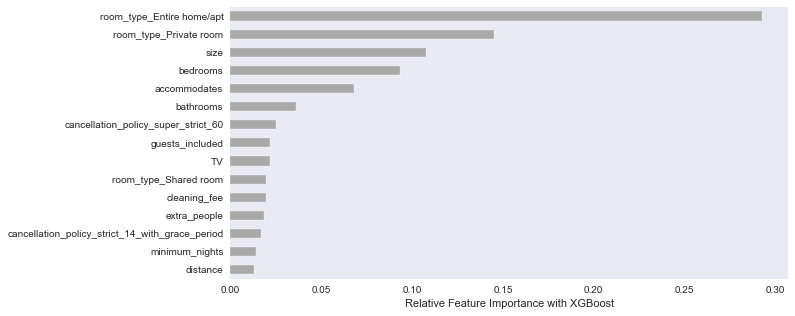

In [90]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost')

Como vemos, las características más importantes son el tamaño, la distancia y la tarifa de limpieza, que representan aproximadamente el 45% del precio diario. Otras características principales son la cantidad de personas que aloja el apartamento, otras tarifas como depósito de seguridad o el precio para personas adicionales, estancia mínima de una noche y los baños.